In [1]:
from memory_profiler import memory_usage
from time import sleep
import torch
from matplotlib import pyplot as plt
import numpy as np
import timeit
import sys
sys.path.insert(0, '..')
from utils import *

In [31]:
def func(var1,var2,normedweight, power, sbins,bins):
    fitter = LegendreFitter(order=0, power=2,lambd=None,max_slope=None,
                            monotonic=False)
    fitter.initialize(m=var2.view(bins,-1),overwrite=True)
    return LegendreIntegral.apply(var1.view(bins,-1),normedweight.view(bins,-1), fitter, sbins)
def func1(var_1,var_2,normedweight,power):
    xx = var_1.view(-1, 1).expand(len(var_1), len(var_1)).view(len(var_1),len(var_1))
    yy = var_1.expand(len(var_1),len(var_1)).view(len(var_1),len(var_1))
    amat = (xx-yy).abs()
    del xx,yy

    amatavg = torch.mean(amat*normedweight,dim=1)
    Amat=amat-amatavg.expand(len(var_1),len(var_1)).view(len(var_1),len(var_1))\
        -amatavg.view(-1, 1).expand(len(var_1), len(var_1)).view(len(var_1),len(var_1))\
        +torch.mean(amatavg*normedweight)
    del amat

    xx = var_2.view(-1, 1).expand(len(var_2), len(var_2)).view(len(var_2),len(var_2))
    yy = var_2.expand(len(var_2),len(var_2)).view(len(var_2),len(var_2))
    bmat = (xx-yy).abs()
    del xx,yy

    bmatavg = torch.mean(bmat*normedweight,dim=1)
    Bmat=bmat-bmatavg.expand(len(var_2),len(var_2)).view(len(var_2),len(var_2))\
        -bmatavg.view(-1, 1).expand(len(var_2), len(var_2)).view(len(var_2),len(var_2))\
        +torch.mean(bmatavg*normedweight)
    del bmat

    ABavg = torch.mean(Amat*Bmat*normedweight,dim=1)
    AAavg = torch.mean(Amat*Amat*normedweight,dim=1)
    BBavg = torch.mean(Bmat*Bmat*normedweight,dim=1)
    del Bmat, Amat

    if(power==1):
        dCorr=(torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight)))
    elif(power==2):
        dCorr=(torch.mean(ABavg*normedweight))**2/(torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))
    else:
        dCorr=((torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))))**power
    return dCorr
def func2(var_1,var_2,normedweight,power):
    xx = var_1.view(-1, 1).repeat(1, len(var_1)).view(len(var_1),len(var_1))
    yy = var_1.repeat(len(var_1),1).view(len(var_1),len(var_1))
    amat = (xx-yy).abs()

    xx = var_2.view(-1, 1).repeat(1, len(var_2)).view(len(var_2),len(var_2))
    yy = var_2.repeat(len(var_2),1).view(len(var_2),len(var_2))
    bmat = (xx-yy).abs()

    amatavg = torch.mean(amat*normedweight,dim=1)
    Amat=amat-amatavg.repeat(len(var_1),1).view(len(var_1),len(var_1))\
        -amatavg.view(-1, 1).repeat(1, len(var_1)).view(len(var_1),len(var_1))\
        +torch.mean(amatavg*normedweight)

    bmatavg = torch.mean(bmat*normedweight,dim=1)
    Bmat=bmat-bmatavg.repeat(len(var_2),1).view(len(var_2),len(var_2))\
        -bmatavg.view(-1, 1).repeat(1, len(var_2)).view(len(var_2),len(var_2))\
        +torch.mean(bmatavg*normedweight)

    ABavg = torch.mean(Amat*Bmat*normedweight,dim=1)
    AAavg = torch.mean(Amat*Amat*normedweight,dim=1)
    BBavg = torch.mean(Bmat*Bmat*normedweight,dim=1)

    if(power==1):
        dCorr=(torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight)))
    elif(power==2):
        dCorr=(torch.mean(ABavg*normedweight))**2/(torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))
    else:
        dCorr=((torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))))**power
    return dCorr

In [32]:
class Loss():
    def __init__(self,):
        self.loss = None
    def backward(self,retain_graph=False,allow_unused=False):
        if self.loss is not None:
            self.loss.backward()
        else:
            raise ValueError("missing loss")
class MoDe(Loss):
    def forward(self,var1,var2,normedweight,power, sbins=2,bins=8):
        self.loss = func(var1,var2,normedweight,power, sbins,bins)
        return self.loss
class DisCo1(Loss):
    def forward(self,var1,var2,normedweight, power):
        self.loss = func1(var1,var2,normedweight, power)
        return self.loss
class DisCo2(Loss):
    def forward(self,var1,var2,normedweight, power):
        self.loss = func2(var1,var2,normedweight, power)
        return self.loss

In [71]:
n = int(4e4)
ns = 2**np.arange(3,15)
var_1 = torch.rand(n)#,dtype=torch.float64)
var_2 = torch.rand(n)#,dtype=torch.float64)
normedweight = torch.rand(n)
power = 2

Text(0.5, 0, 'batch_size')

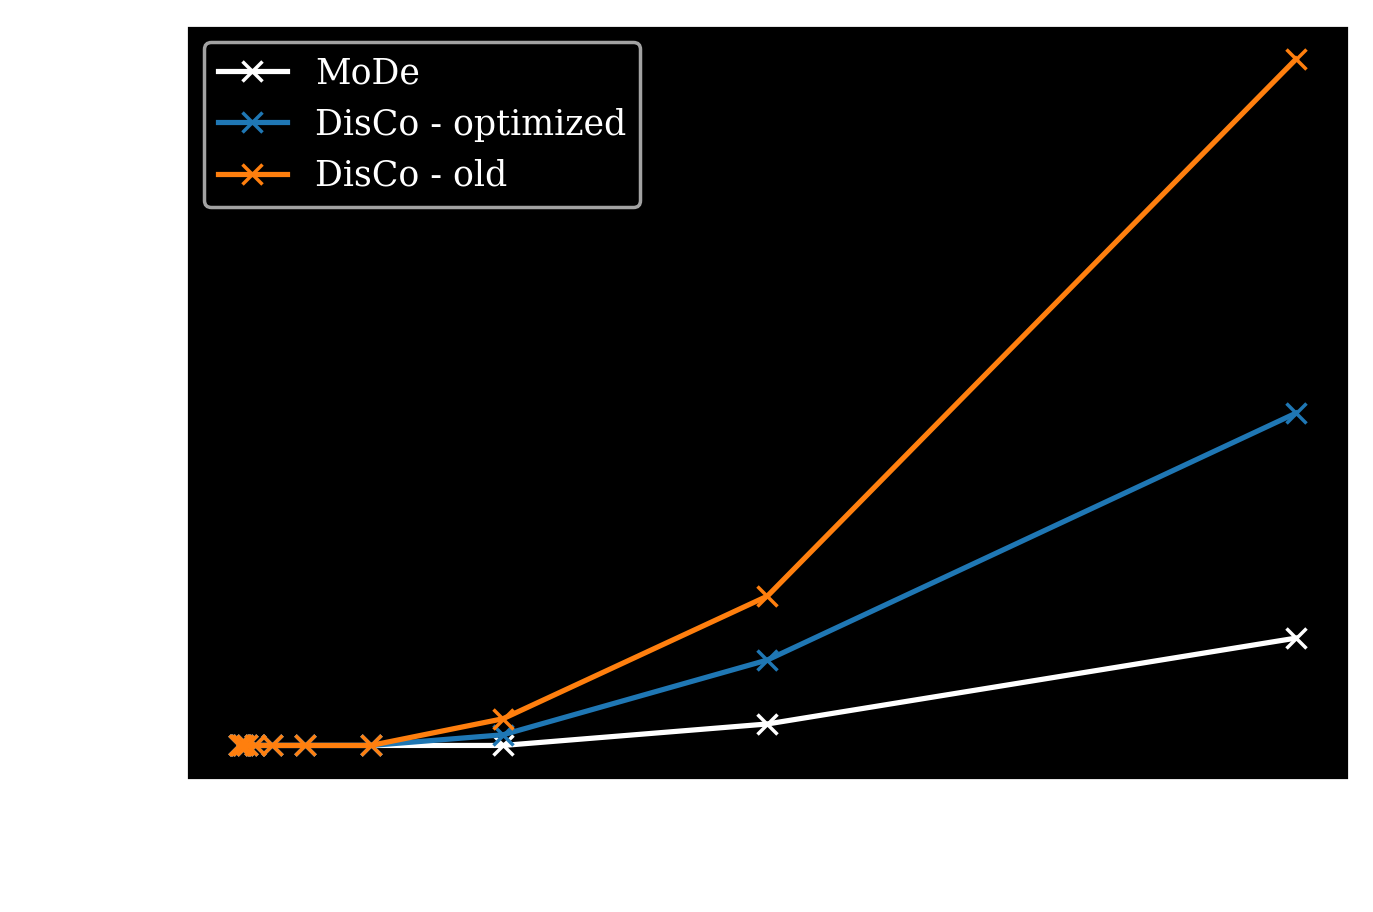

In [98]:
mems0= []
mems1= []
mems2= []
mems0_= []
mems1_= []
mems2_= []
models = [(MoDe(),DisCo1(),DisCo2()) for i in range(len(ns))]
for i,n in enumerate(ns):
    x = var_1[:n].detach()
    mode,disco1,disco2 = models[i]
    mem_usage0 = memory_usage((mode.forward,(x,var_2[:n],normedweight[:n],power),),interval=0.1)
    mems0.append(mem_usage0)

    sleep(0.5)
    mem_usage1 = memory_usage((disco1.forward,(x,var_2[:n],normedweight[:n],power),),interval=0.1)
    mems1.append(mem_usage1)
    
    sleep(0.5)
    mem_usage2 = memory_usage((disco2.forward,(x,var_2[:n],normedweight[:n],power),),interval=0.1)
    mems2.append(mem_usage2) 

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=250)
ax.errorbar(ns,[max(x) for x in mems0],label="MoDe",c='white',marker="x")
ax.errorbar(ns,[max(x) for x in mems1],label="DisCo - optimized",c='tab:blue',marker="x")
ax.errorbar(ns,[max(x) for x in mems2],label="DisCo - old",c='tab:orange',marker="x")
ax.legend()
ax.set_ylabel("max mem. usage [MB]")
ax.set_xlabel("batch_size")

In [94]:
mems0= []
mems1= []
mems2= []
mems0_= []
mems1_= []
mems2_= []
requires_grad = True
models = [(MoDe(),DisCo1(),DisCo2()) for i in range(len(ns))]
for i,n in enumerate(ns):
    x = var_1[:n].requires_grad_(requires_grad)
    mode,disco1,disco2 = models[i]
    mem_usage0 = memory_usage((mode.forward,(x,var_2[:n],normedweight[:n],power),),interval=0.1)
    mems0.append(mem_usage0)
    mem_usage0 = memory_usage((mode.backward),interval=0.1,max_iterations=1)
    mems0_.append(mem_usage0)

    sleep(0.5)
    mem_usage1 = memory_usage((disco1.forward,(x,var_2[:n],normedweight[:n],power),),interval=0.1)
    mems1.append(mem_usage1)
    mem_usage1 = memory_usage((disco1.backward),interval=0.1,max_iterations=1)
    mems1_.append(mem_usage1)

    sleep(0.5)
    mem_usage2 = memory_usage((disco2.forward,(x,var_2[:n],normedweight[:n],power),),interval=0.1)
    mems2.append(mem_usage2) 
    mem_usage2 = memory_usage((disco2.backward),interval=0.1,max_iterations=1)
    mems2_.append(mem_usage2) 

Text(0.5, 0, 'batch_size')

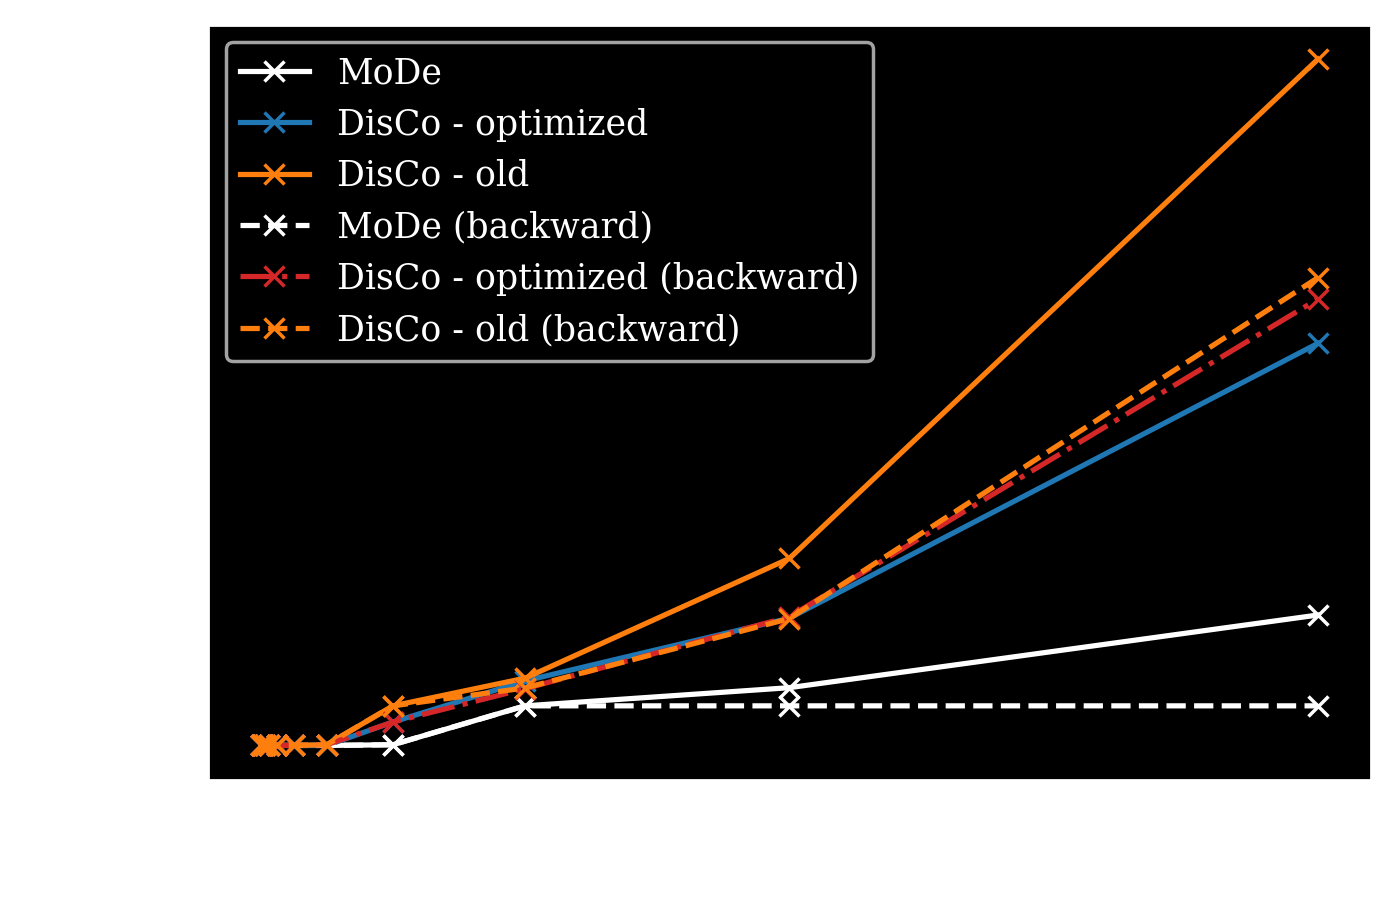

In [95]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=250)
ax.errorbar(ns,[max(x) for x in mems0],label="MoDe",c='white',marker="x")
ax.errorbar(ns,[max(x) for x in mems1],label="DisCo - optimized",c='tab:blue',marker="x")
ax.errorbar(ns,[max(x) for x in mems2],label="DisCo - old",c='tab:orange',marker="x")
ax.errorbar(ns,[max(x) for x in mems0_],label="MoDe (backward)",c='white',marker="x",ls='--')
ax.errorbar(ns,[max(x) for x in mems1_],label="DisCo - optimized (backward)",c='tab:red',marker="x",ls='-.')
ax.errorbar(ns,[max(x) for x in mems2_],label="DisCo - old (backward)",c='tab:orange',marker="x",ls='--')
ax.legend()
ax.set_ylabel("max mem. usage [MB]")
ax.set_xlabel("batch_size")

In [81]:
times0_= []
times1_= []
times2_= []
var_1.requires_grad_(True)
for n in ns:
    time = timeit.timeit(lambda: func(var_1[:n],var_2[:n],normedweight[:n],power,2,8).backward(), number=10,
                         #'gc.enable()'
                        )
    times0_.append(time)
for n in ns:
    time = timeit.timeit(lambda: func1(var_1[:n],var_2[:n],normedweight[:n],power).backward(),number=10
                         #'gc.enable()'
                        )
    times1_.append(time)
for n in ns:
    time = timeit.timeit(lambda: func2(var_1[:n],var_2[:n],normedweight[:n],power).backward(), number=10,
                         #'gc.enable()'
                        )
    times2_.append(time)

In [79]:
times0= []
times1= []
times2= []
for n in ns:
    time = timeit.timeit(lambda: func(var_1[:n],var_2[:n],normedweight[:n],power,2,8), number=10,
                         #'gc.enable()'
                        )
    times0.append(time)
for n in ns:
    time = timeit.timeit(lambda: func1(var_1[:n],var_2[:n],normedweight[:n],power),number=10
                         #'gc.enable()'
                        )
    times1.append(time)
for n in ns:
    time = timeit.timeit(lambda: func2(var_1[:n],var_2[:n],normedweight[:n],power), number=10,
                         #'gc.enable()'
                        )
    times2.append(time)

Text(0.5, 0, 'batch_size')

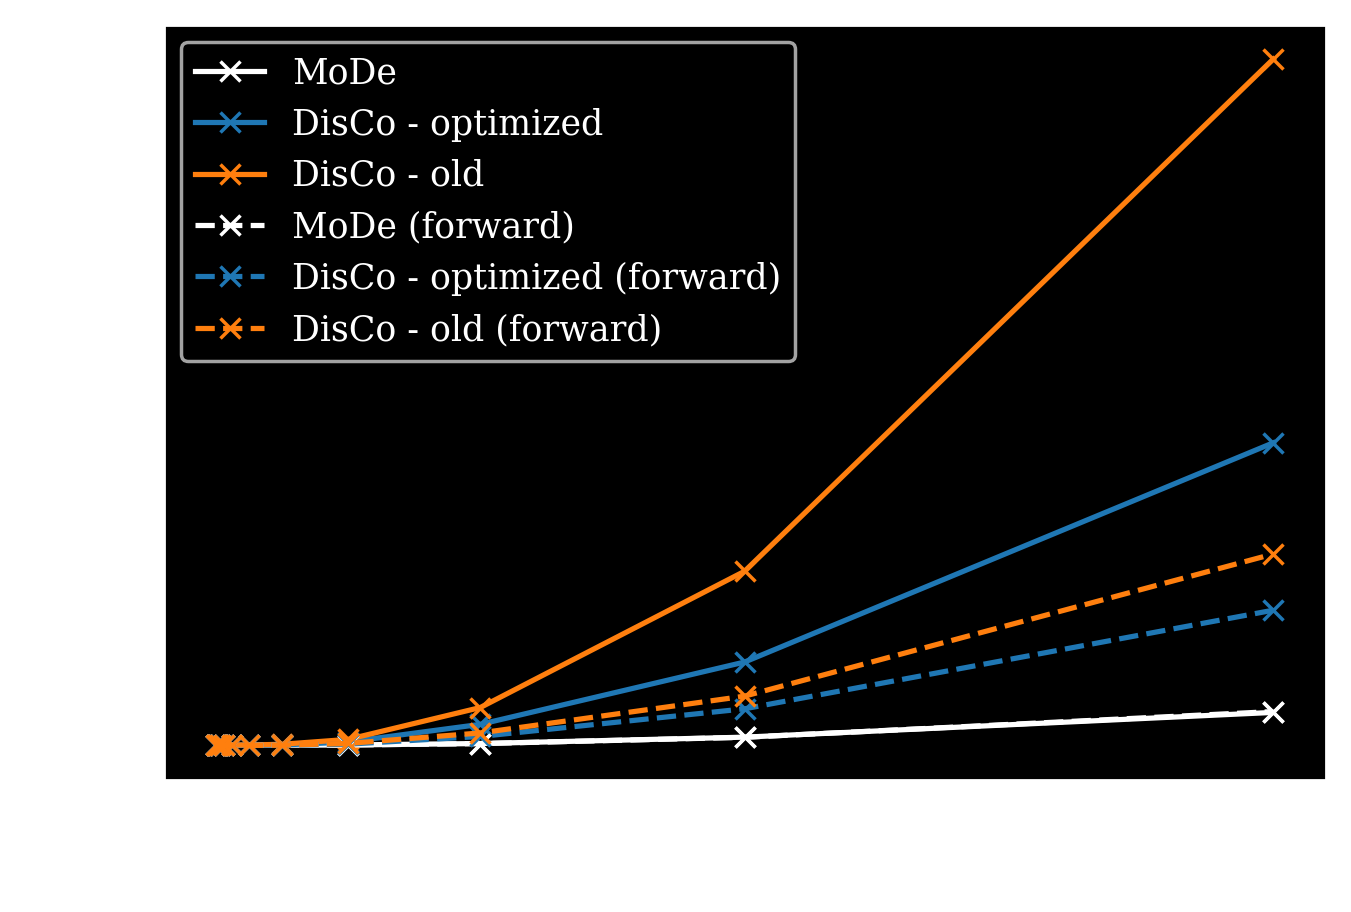

In [90]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=250)
ax.errorbar(ns,times0_,label="MoDe",c='white',marker="x")
ax.errorbar(ns,times1_,label="DisCo - optimized",c='tab:blue',marker="x")
ax.errorbar(ns,times2_,label="DisCo - old",c='tab:orange',marker="x")
ax.errorbar(ns,times0,label="MoDe (forward)",c='white',marker="x",ls='--')
ax.errorbar(ns,times1,label="DisCo - optimized (forward)",c='tab:blue',marker="x",ls='--')
ax.errorbar(ns,times2,label="DisCo - old (forward)",c='tab:orange',marker="x",ls='--')
ax.legend()
ax.set_ylabel("time [s]")
ax.set_xlabel("batch_size")